Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI Active Learning Uncertainty Exploration & Results Analysis

There are two sections in this notebook: 

1.) How to visualize uncertainty from given unlabeled samples

2.) How to analyze results once the active learning scripts have been run to completion

## Part 1: Uncertainty Visualization

Visualization of the spatial uncertainty maps provides an understanding of what particular regions of the unlabeled image the model is not confident about. The below example will showcase uncertainty on a few examples from the training set.

### Setup Imports

In [21]:
import os
import json
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt

from monai.networks.nets import FlexibleUNet
from monai.data import DataLoader, Dataset
from monai.transforms import (
Compose,
LoadImaged,
EnsureChannelFirstd,
Resized,
ScaleIntensityd,
EnsureTyped
)

### Dataset, Model and Transform Definitions

In [26]:
# Paths, to be defined by user
data_root = os.path.normpath('/to/be/defined')
json_path = os.path.normpath('/to/be/defined')
model_ckpt = os.path.normpath('/to/be/defined')

# Load Json file
with open(json_path, 'rb') as f:
    json_data = json.load(f)
f.close()

# Transforms
unl_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureChannelFirstd("image"),
        Resized(keys=["image"],
                spatial_size=[736, 480],
                mode=["bilinear"]
                ),
        ScaleIntensityd(keys=["image"]),
        EnsureTyped(keys=["image"])
    ]
)

# Append data paths to data root
unl_d = json_data['train']
for idx, each_sample in enumerate(unl_d):
    unl_d[idx]['image'] = os.path.join(data_root, unl_d[idx]['image'])
    unl_d[idx]['label'] = os.path.join(data_root, unl_d[idx]['label'])

# Create Data Loader
unl_ds = Dataset(
    data=unl_d, transform=unl_transforms)
unl_loader = DataLoader(unl_ds, batch_size=1, shuffle=False)

# Model Definition
device = torch.device("cuda")

model = FlexibleUNet(
    in_channels=3,
    out_channels=2,
    backbone="efficientnet-b0",
    pretrained=True,
    is_pad=False,
).cuda()

# Load Model Weights
model.load_state_dict(torch.load(model_ckpt))

# Please note that the model is being put to 'train' mode explicitly for Monte-Carlo simulations
model.train()
print('We are set to visualize some cool uncertainty ...')

We are set to visualize some cool uncertainty ...


/scratch_2/robo_tool_dataset_2023/robo_tool/dv13_00098.png
Variance for image: /scratch_2/robo_tool_dataset_2023/robo_tool/dv13_00098.png is: 0.004289678763598204


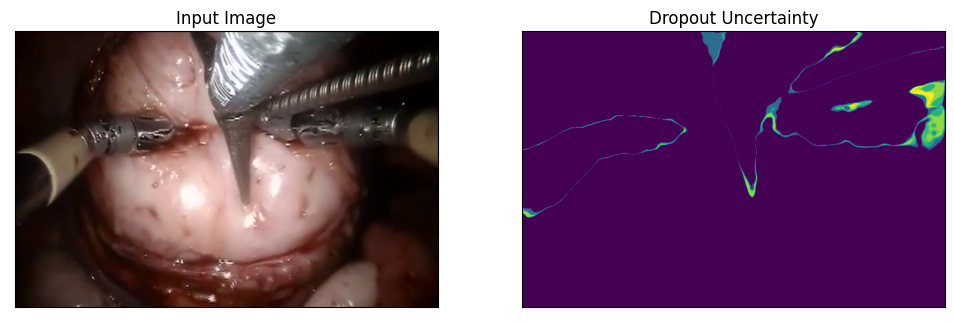

In [28]:
with torch.no_grad():
    counter = 0
    for unl_data in unl_loader:
        counter = counter + 1
        if counter == 89:
            unl_inputs = unl_data["image"].to(device)

            accum_unl_outputs = []

            for mc in range(10):
                unl_outputs = model(unl_inputs)

                # Activate the output with Softmax
                unl_act_outputs = torch.softmax(unl_outputs, dim=1)

                # Accumulate
                accum_unl_outputs.append(unl_act_outputs)

            # Stack it up, Squeeze and send to CPU
            accum_tensor = torch.stack(accum_unl_outputs)
            accum_tensor = torch.squeeze(accum_tensor)
            accum_numpy = accum_tensor.to('cpu').numpy()
            accum_numpy = accum_numpy[:, 1:, :, :]

            vol_input = accum_numpy.astype(dtype='float32')
            # Threshold values less than or equal to zero
            threshold = 0.0005
            vol_input[vol_input <= 0] = threshold
            variance = np.sum(np.nanvar(vol_input, axis=0), axis=0)

            #score_list.append(np.nanmean(variance))
            print(unl_data['image_meta_dict']['filename_or_obj'][0])
            print('Variance for image: {} is: {}'.format(unl_data['image_meta_dict']['filename_or_obj'][0], np.nanmean(variance)))

            # Plot with matplotlib and save slices
            show_img = np.fliplr(np.swapaxes(np.squeeze(unl_inputs.to('cpu').numpy()), 0, 2))
            plt.figure(1, figsize=(12, 4))
            plt.subplot(1,2,1)
            plt.imshow(show_img)
            plt.xticks([])
            plt.yticks([])
            plt.title('Input Image')
            plt.subplot(1,2,2)
            plt.imshow(np.rot90(variance, 3))
            plt.xticks([])
            plt.yticks([])
            plt.title('Dropout Uncertainty')
            plt.show()
            break

## Part 2: Results Analysis

Working on /home/vishwesh/Code/active_learning/active_learning_2022/monai_al_tutorial_apr_2023/robo_tool_results/random_i15_q15_iter5k
Working on /home/vishwesh/Code/active_learning/active_learning_2022/monai_al_tutorial_apr_2023/robo_tool_results/variance_i15_q15_iter5k


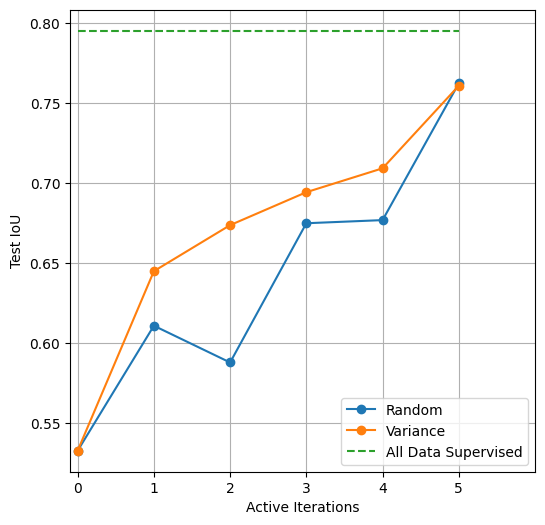

In [29]:
base_path = os.path.normpath('/to/be/defined/results/path/from/runner.sh/goes/here')

method_name_list = {
                    'random_i15_q15_iter5k': 'Random',
                    'variance_i15_q15_iter5k': 'Variance',
                    }

active_iters = 6
x = range(0, active_iters)
legend_list = []

plt.figure(1, figsize=(6, 6))
for each_method, legend_name in method_name_list.items():
    method_path = os.path.join(base_path, each_al, each_method)
    legend_list.append(legend_name)
    per_active_dice_score = []

    trial_path = os.path.join(base_path, each_method)
    print('Working on {}'.format(trial_path))
    pickle_path = os.path.join(trial_path, 'all_metrics.pickle')
    with open(pickle_path, 'rb') as handle:
        data = pickle.load(handle)
    handle.close()
    for each_iter in range(active_iters):
        iter_key = 'model_' + str(each_iter)
        max_val = np.max(data[iter_key]['test_iou'])

        per_active_dice_score.append(max_val)

    plt.plot(x, per_active_dice_score, '-o')

# Get Full dataset result
all_data_result_path = os.path.join(base_path, 'all_data_iter5k', 'all_metrics.pickle')
with open(all_data_result_path, 'rb') as handle:
    all_data_result = pickle.load(handle)
handle.close()
all_data_score = all_data_result['model_0']['test_iou']
all_data_list = [all_data_score]*active_iters
plt.errorbar(list(range(0, active_iters)), all_data_list, fmt='--', ecolor='black')
legend_list.append('All Data Supervised')

plt.grid()
plt.xlabel('Active Iterations')
plt.ylabel('Test IoU')
plt.xlim([-0.1, active_iters])
plt.xticks(list(range(0, active_iters)))
plt.legend(legend_list)
plt.show()